In [345]:
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 


%matplotlib inline 

In [2]:
# Global parameters
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'
itf_path = 'demo_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans'


In [307]:
# cl.generate_sky_region_files('ryan_data_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans', pixels, nside, n)

In [9]:
true_count_set, mergedCounter_dict, mergedTime_dict = cl.accessible_clusters(pixels, infilename=train_path)
true_count = len(true_count_set)
print('True count of clusters: {}'.format(true_count))

right, wrong, ids_right, ids_wrong = cl.test_clusters(pixels, train_path, util.lunation_center(n), \
                                                    dt=dt,rad=cr)

print('Using our optimal parameters we got {0} percent of clusters with {1} percent errors.'.format(right/true_count,wrong/true_count))
print('We got',right,'right and',wrong,'wrong out of total',true_count)

True count of clusters: 890
Starting run...
100%

Run finished!
Using our optimal parameters we got 0.7842696629213484 percent of clusters with 0.0056179775280898875 percent errors.
We got 698 right and 5 wrong out of total 890


In [18]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

Starting run...
100%

Run finished!


In [41]:
# tr_clust_ids

In [198]:
cl = imp.reload(cl)
res_dict = cl.get_res_dict(train_path,[281],nside,n)

In [443]:
agg_dict = defaultdict(list)
for k,v in tr_clust_ids.items():
    # k is the tracklet id, v is the cluster id 
    agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

In [442]:
# agg_dict
12 in tr_clust_ids.values()

False

In [444]:
po = []
for k,v in agg_dict.items():
    if v!=[]:
        po.append(k)
    else:
        print(type(k))
#         print([ki for ki,vi in tr_clust_ids.items() if vi==12 or vi==11])
np.array(po)

array([1052, 1050,   43,  443,  245,  122, 1123,   69,  273, 1113,  487,
        730,  682,  733,  713,  798,  664,  130,  195,  770,  723,  767,
        735,  193,  842,  161,  734, 1275, 1360,  494,  332, 1571, 1362,
        855,  794,  440,  302,  190,  314, 1114,  345,  416,  241,  512,
        260,  525,  499,  434,  361,  428,  331,  530,  274,  488, 1276,
        848, 1595,  853,  385,  306,  394,  445,  469,  478,  337,  412,
       1662,  352,  433,  526,  360,  442,  362,  438,  517,  439,  858,
        389, 1599,  497,  441, 1714,  492, 1726,  571,  700,  629,  679,
        787,  584,  658,  778,  681,  570,  701,  876,  625,   54,  726,
        824,  732,  757,  668,  561,  674,  667,  724,  631,  656,  677,
        623,  638,  659,  662,  646,  670, 2540,  651,  714,  805,  808,
       2555, 2581, 2588,  725,  706,  729,  708,  812,  809,  665,  731,
        775,  727,  758,  820,  834,  883,  799,  765,  769,  837, 1472,
       1273,  854,  911,  373,  983, 1030, 1009, 13

In [253]:
a_obs3 = [itm for ob in agg_dict[1052] for itm in ob]
# [i[0] for i in a_obs3])
sorted([(i[0],i[1]) for i in a_obs3],key=lambda x: x[1])

[('K13CI6G_018', 2457312.746549),
 ('K13CI6G_018', 2457312.752789),
 ('K13CI6G_018', 2457312.763969),
 ('K13CI6G_018', 2457312.768859),
 ('K13CI6G_018', 2457312.773669),
 ('K13CI6G_019', 2457314.750439),
 ('K13CI6G_019', 2457314.756469),
 ('K13CI6G_019', 2457314.761319),
 ('K13CI6G_019', 2457314.766039),
 ('K13CI6G_019', 2457314.770859),
 ('K13CI6G_020', 2457316.858239),
 ('K13CI6G_020', 2457316.869239),
 ('K13CI6G_020', 2457316.880229),
 ('K13CI6G_020', 2457316.891239)]

In [37]:
print('We have {} observations in cluster id 3'.format(len(a_obs3)))

We have 16 observations in cluster id 3


In [491]:
g,gdot = 0.4,0.0
idx = 2360
cl = imp.reload(cl)
params, loss_val, chisq, chisq_arr = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx])

In [492]:
chisq_arr

[10.95120730193689,
 12.329977651639322,
 11.332595170554765,
 10.336123910322627,
 10.590439602398099,
 10.58944311913614,
 10.298373970734342,
 6.9915583632712668,
 7.048193905169934,
 7.5253458594744114,
 7.077844954275573,
 6.7675169205228345,
 7.3018270155147649,
 7.2619196087747468,
 6.8582551621765697,
 6.9267648288674426,
 6.9744664719630762,
 7.1086855281579231,
 13.151677618723104,
 12.956083635063628,
 13.563864111208295,
 12.914698533979328,
 13.285422186737108,
 13.815121757351431,
 19.646751027363528,
 19.606841556719292,
 19.797825103627581,
 20.406742668092999,
 20.275098640521787,
 20.51291285320525,
 20.555951204861113]

In [493]:
util.lunation_center(-14)

2457308.5

In [494]:

a_obs = [ob for trkl in agg_dict[idx] for ob in trkl]
[(ob[0],float(round(ob[3],5)),float(round(ob[4],5)),ch) for ob,ch in zip(a_obs,chisq_arr)]

[('K12D06E_021', -0.12993, 0.02305, 10.95120730193689),
 ('K12D06E_021', -0.12995, 0.02306, 12.329977651639322),
 ('K12D06E_021', -0.12999, 0.02307, 11.332595170554765),
 ('K12D06E_021', -0.13013, 0.02314, 10.336123910322627),
 ('K12D06E_021', -0.13015, 0.02315, 10.590439602398099),
 ('K12D06E_021', -0.13017, 0.02316, 10.58944311913614),
 ('K12D06E_021', -0.13018, 0.02317, 10.298373970734342),
 ('K12D06E_022', -0.13771, 0.02695, 6.9915583632712668),
 ('K12D06E_022', -0.13774, 0.02697, 7.048193905169934),
 ('K12D06E_022', -0.13776, 0.02698, 7.5253458594744114),
 ('K12D06E_022', -0.13778, 0.02699, 7.077844954275573),
 ('K12D06E_022', -0.1378, 0.027, 6.7675169205228345),
 ('K12D06E_022', -0.13792, 0.02706, 7.3018270155147649),
 ('K12D06E_022', -0.13804, 0.02711, 7.2619196087747468),
 ('K12D06E_022', -0.13806, 0.02713, 6.8582551621765697),
 ('K12D06E_022', -0.13811, 0.02716, 6.9267648288674426),
 ('K12D06E_022', -0.13816, 0.02718, 6.9744664719630762),
 ('K12D06E_022', -0.1382, 0.0272, 7.10

In [313]:
agg_dict[12]

[]

In [495]:
cl = imp.reload(cl)
par_results,chi_res  = {},[]
g,gdot = 0.4,0.0
idxs = [1052,443,1815,560,776,2449]
for idx in po:
    all_res = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx])
    par_results[idx] = all_res[0]
    chi_res.append(all_res[2])

/Users/paulblankley/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


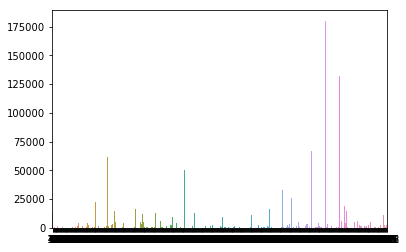

In [357]:
# del_idx = chi_res.index(max(chi_res))
# del chi_res[del_idx]
# del po[del_idx]

sns.barplot(po,chi_res)

# sorted(chi_res,reverse=True)


In [497]:
xx=10.
print('mean rms',np.mean(chi_res),'median rms',np.median(chi_res),\
              'number below {}'.format(xx),len([i for i in chi_res if i<xx]))
print('percent below {}'.format(xx), len([i for i in chi_res if i<xx])/len(chi_res))

mean rms 1.46447423768 median rms 0.674120530258 number below 10.0 696
percent below 10.0 0.9872340425531915


In [499]:
po[chi_res.index(sorted(chi_res,reverse=True)[0])]

2122

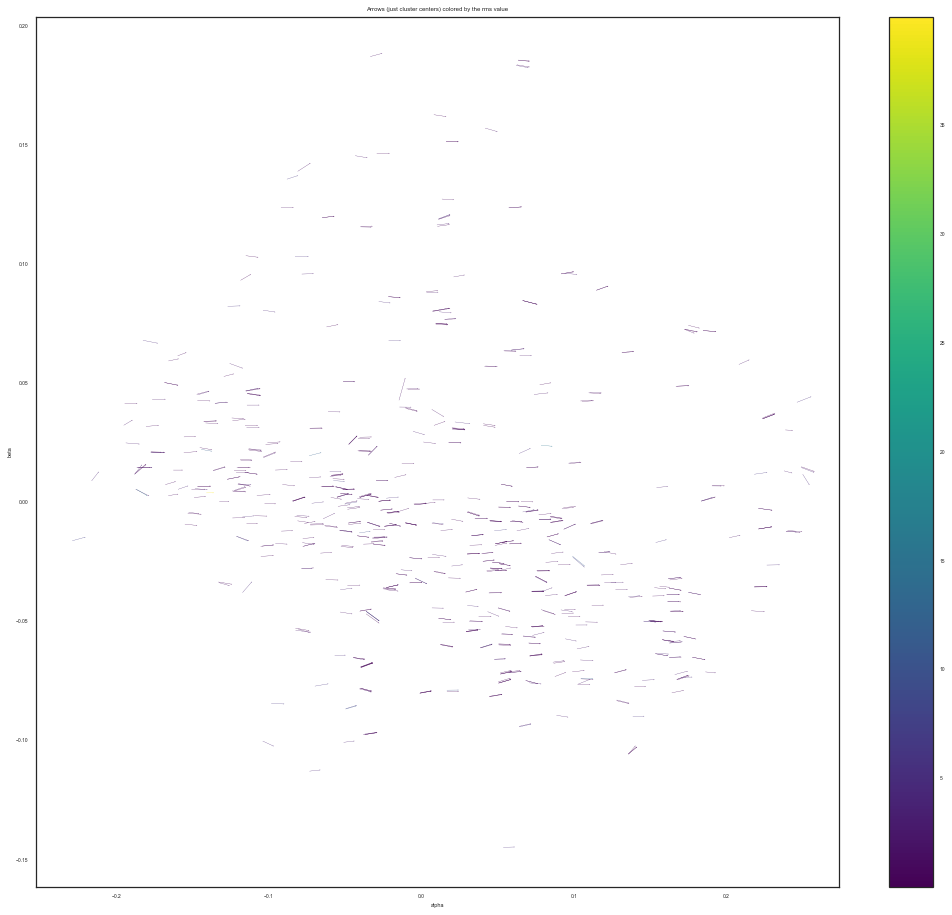

In [501]:
cl = imp.reload(cl)
cl.vis_arrows_by_rms(par_results,chi_res)

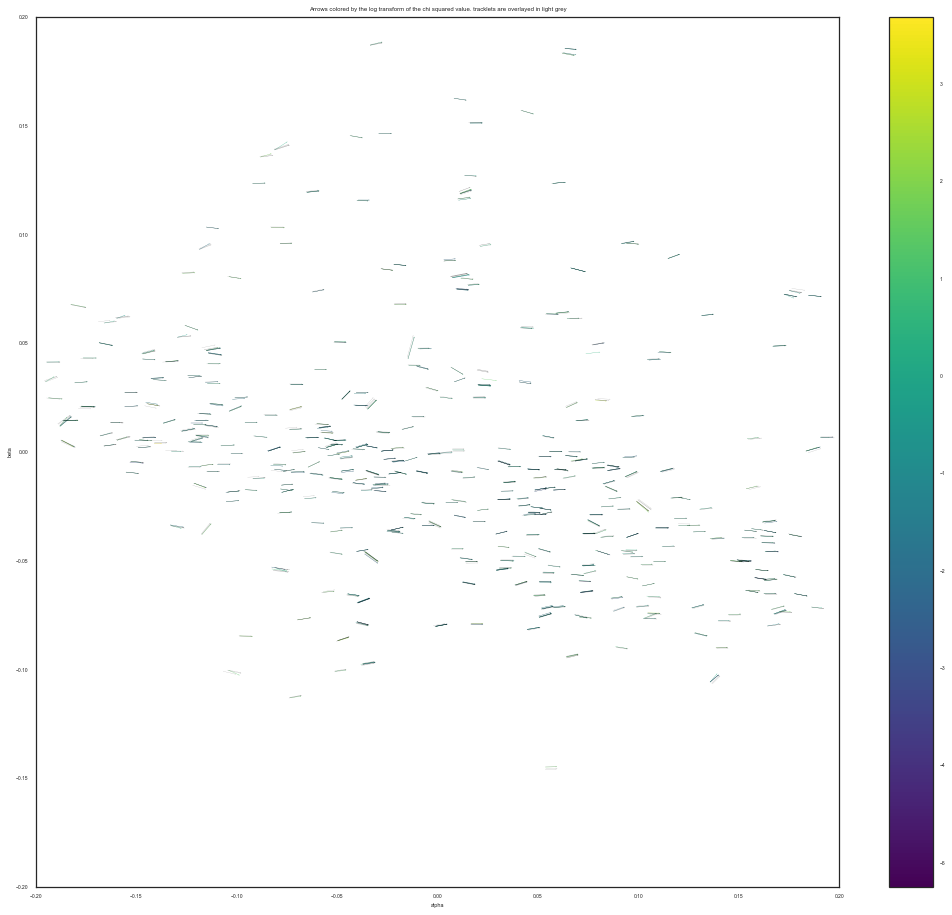

In [508]:
cl = imp.reload(cl)
sns.set(font_scale=.5)
sns.set_style('white')
# ggdots = cl.vis_arrows_by_chi_with_trkl({'k':par_results[2122]},agg_dict,[2122],util.lunation_center(n),chi_res)
ggdots = cl.vis_arrows_by_chi_with_trkl(par_results,agg_dict,po,util.lunation_center(n),chi_res)

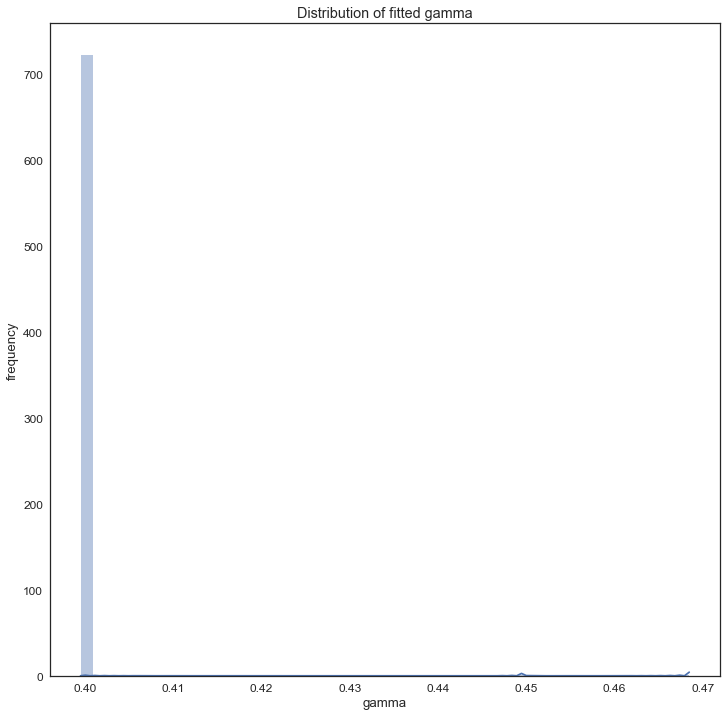

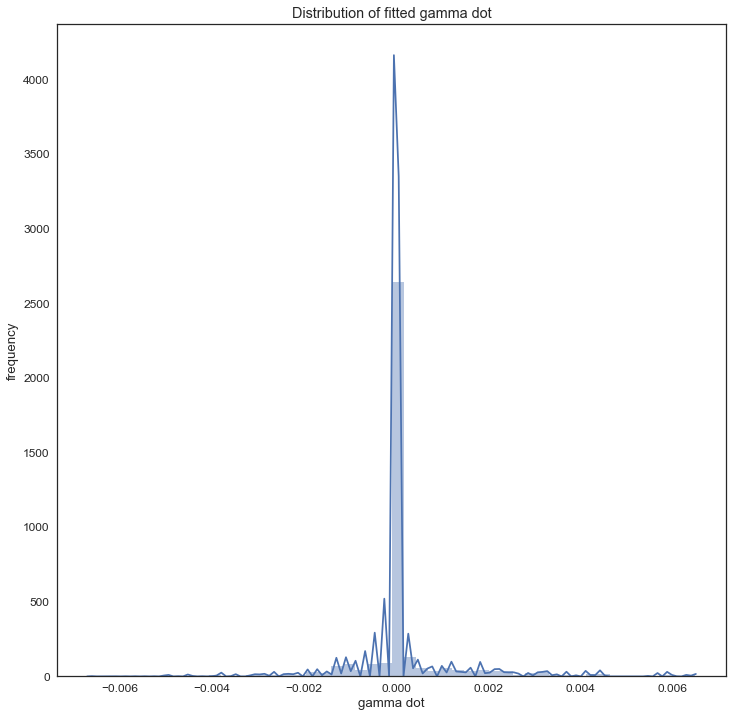

In [425]:
gd_dist = [i[1][0] for i in ggdots]
gdd_dist = [i[1][1] for i in ggdots]
sns.set(font_scale=1.2)
sns.set_style('white')
fig,ax = plt.subplots(figsize=(12,12))
sns.distplot(gd_dist)
plt.title('Distribution of fitted gamma')
plt.xlabel('gamma')
plt.ylabel('frequency')
plt.show()


fig,ax = plt.subplots(figsize=(12,12))
sns.distplot(gdd_dist)
plt.title('Distribution of fitted gamma dot')
plt.xlabel('gamma dot')
plt.ylabel('frequency')
plt.show()

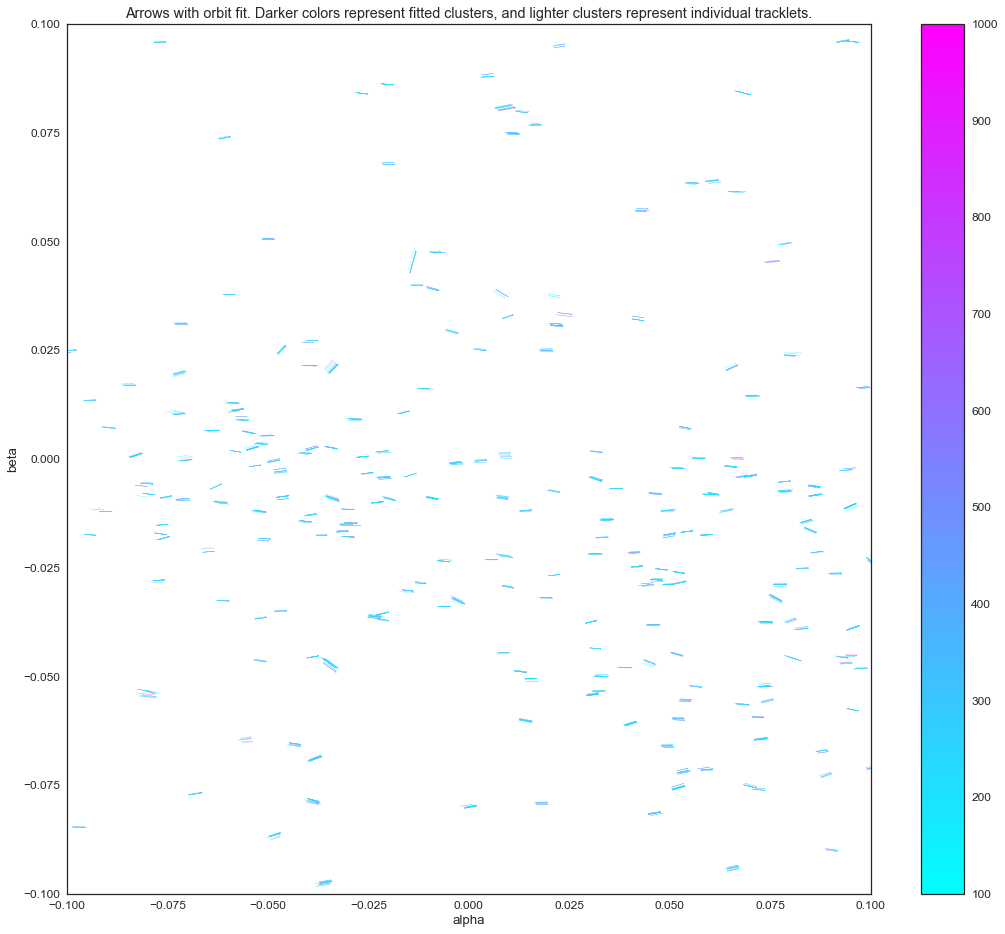

In [426]:
cl = imp.reload(cl)
cl.visualize(par_results,agg_dict,po,util.lunation_center(n))

In [428]:
chir = np.array(chi_res)
ch_one_sd = [i for i in chir if i<(chir.mean()+chir.std())]

In [429]:
chir.mean(), np.median(chir), chir.std()

(3221.687056799447, 187.60365178263601, 13265.784553825317)

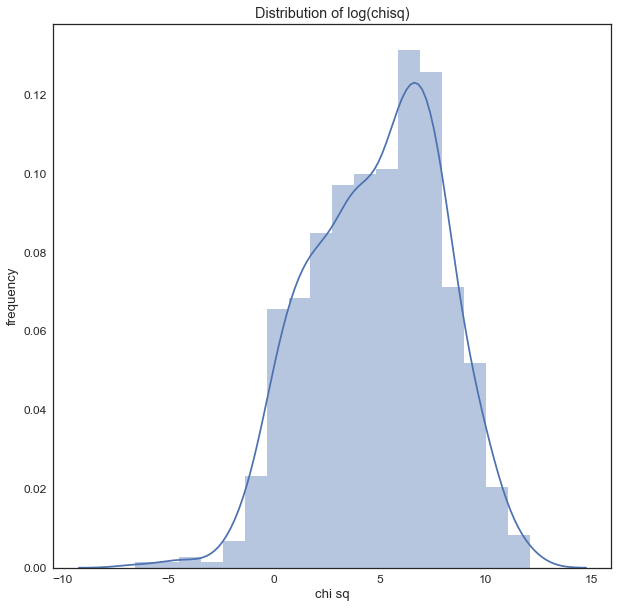

In [433]:
fig,ax = plt.subplots(figsize=(10,10))
sns.distplot(np.log(chir))
plt.title('Distribution of log(chisq)')
plt.xlabel('chi sq')
plt.ylabel('frequency')
plt.show()

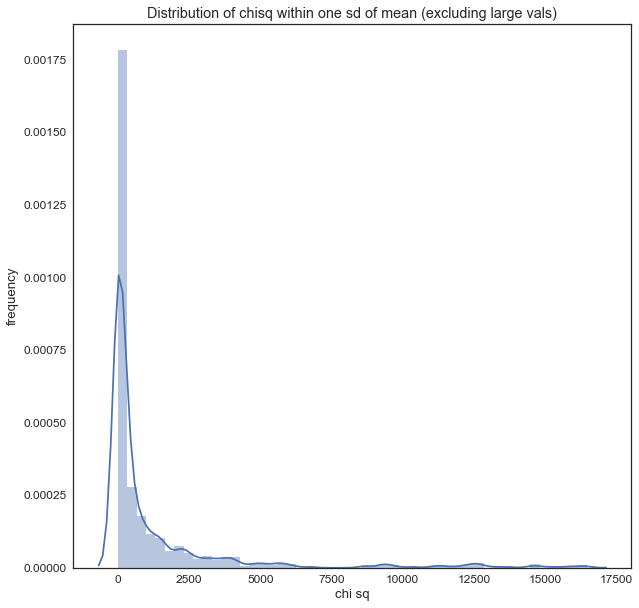

In [434]:
fig,ax = plt.subplots(figsize=(10,10))
sns.distplot(ch_one_sd)
plt.title('Distribution of chisq within one sd of mean (excluding large vals)')
plt.xlabel('chi sq')
plt.ylabel('frequency')
plt.show()